# Classifying Handwritten Digits Using Neural Networks

## Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision.datasets import MNIST

## Dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a famous dataset that was used in the first practical applications of the backpropagation algorithm by Yann LeCun (Turing Award recipient, and Chief AI Scientist at Meta). It's a labeled dataset collected by the National Institute of Standards and Technology consisting of images of handwritten digits from high schoolers and US Census Bureau employees.

In [ ]:
dataset = MNIST('./sample_data', train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



### What is contained in this dataset?

In [ ]:
print(f"The MNIST training set has {len(dataset)} samples")
sample = next(iter(dataset))
print(f"A sample from MNIST looks like: {sample}")

The MNIST training set has 60000 samples
A sample from MNIST looks like: (<PIL.Image.Image image mode=L size=28x28 at 0x7FAACCD04D10>, 5)


`PIL` (frequently called Pillow) stands for Python Image Library. You can find the documentation [here](https://pillow.readthedocs.io/en/stable/).

---

**Question:** How many images are in the MNIST training set?

**Answer:** $ 60000 $

---

**Question:** How big is each image in the dataset?

**Answer:** $ 28 \times 28 $

For a benchmark dataset like MNIST, the image size is standardized. But in practice, you might want to check the size of each image programmatically (More on that later).

---

**Question:** What does `mode=L` mean?

**Answer:** Black and white image

In [ ]:
img, label = sample

### What does a single sample from the dataset look like?

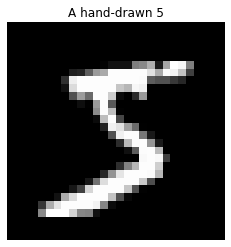

In [ ]:
# TODO: Plot `img`
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.title(f"A hand-drawn {label}")
plt.show()

### How many examples are there for each class (type of digit)?

In [ ]:
# TODO: Calculate Frequencies
frequencies = {}
for img, label in dataset:
  if label not in frequencies:
    frequencies[label] = 0
  frequencies[label] += 1

  # Just checking that all images are the same size.
  # Alternatively: Plot the size of the images
  assert img.size == (28, 28)

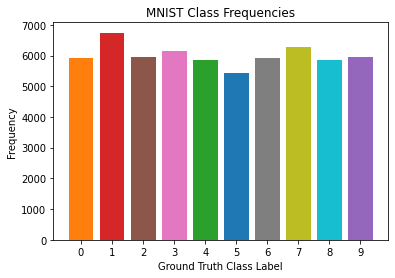

In [ ]:
# TODO: Plot Frequencies
plt.bar(x=frequencies.keys(),
        height=frequencies.values(),
        color=sns.color_palette(),
        tick_label=[str(label) for label in frequencies])
plt.title("MNIST Class Frequencies")
plt.xlabel("Ground Truth Class Label")
plt.ylabel("Frequency")
plt.show()

### Let's look at samples from each class

In [ ]:
NUM_CLASSES = 10
SAMPLES_PER_CLASS = 5

In [ ]:
# TODO: Find `SAMPLES_PER_CLASS` images for each class in MNIST
samples = {label: [] for label in range(NUM_CLASSES)}
for img, label in dataset:
  if all(len(preview) == SAMPLES_PER_CLASS for preview in samples.values()):
    break
  if len(samples[label]) < SAMPLES_PER_CLASS:
    samples[label].append(img)

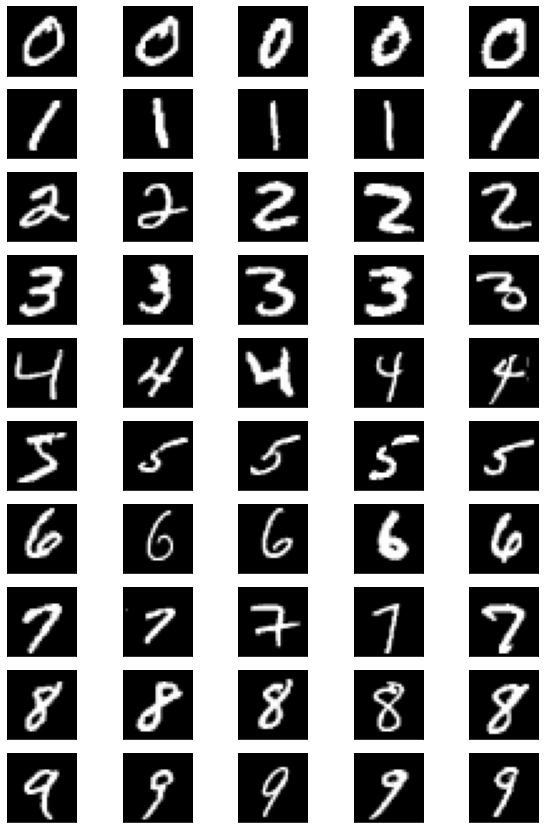

In [ ]:
# TODO: Plot all collected samples
fig, ax = plt.subplots(NUM_CLASSES, SAMPLES_PER_CLASS, figsize=(10, 15))
for label, previews in samples.items():
  for idx, preview in enumerate(previews):
    ax[label, idx].imshow(preview, cmap=plt.cm.gray)
    ax[label, idx].tick_params(
        axis='both',
        which='both',
        left=False,
        bottom=False,
        labelbottom=False,
        labelleft=False
    )
fig.show()

## Data Preparation.

Before training our model, it's good to clean up our data to make the task more tractable and take some additional steps to safeguard against overfitting/underfitting.

### Preprocessing Transforms

**Question:** What is the best way to represent the target variable for the neural network?

Let's say we have an input image:

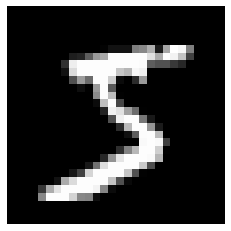

In [ ]:
img, label = next(iter(dataset))

plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

For this sample input, we want the network to predict $ 5 $. However, there are some issues with teaching the network to predict a value $ \hat{y} \in [0,9] $...there's no inherent ordering in shape of digits and there's no way to express uncertainty between two classes.

For example, how would the network express that it's not sure if a digit is a $ 1 $ or a $ 7 $? What does it mean when $ \hat{y} = 3.5 $?

**Answer:** A better represetnation for our targets uses [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics).


Instead of having our label be $ y = 5 $, we will set our target to:

$ y = \begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \end{bmatrix} $

That way, there's no implicit ordering in the task, and if the network is equally sure that an input is a 1 or a 7, it can express the prediction like this:

$ \hat{y} = \begin{bmatrix} 0 & 0.5 & 0 & 0 & 0 & 0 & 0 & 0.5 & 0 & 0 \end{bmatrix} $

In [ ]:
import torch.nn.functional as F
from torchvision import transforms

In [ ]:
# TODO: Define a transform to one-hot encode all samples
class OneHotEncode(object):
  """One-hot encode the labels in the dataset."""
  def __call__(self, label):
    if isinstance(label, int):
      label = torch.Tensor([target]).long()
    return F.one_hot(label, num_classes=NUM_CLASSES)

In [ ]:
# TODO: Add some preprocessing transforms
preprocessing = transforms.Compose([
  # Convert the image from a PIL.Image.Image to a torch.FloatTensor.
  transforms.ToTensor(),
  # Normalize the inputs using the mean and stddeve of the dataset.
  transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
dataset = MNIST('./sample_data', 
                train=True, 
                transform=preprocessing, 
                target_transform=OneHotEncode())

### Split the dataset

In [ ]:
TRAIN_RATIO = 0.8
train_size = int(len(dataset) * TRAIN_RATIO)
val_size = len(dataset) - train_size
print(f"Train set percentage: {TRAIN_RATIO * 100:.2f}%")
print(f"Validation set percentage: {(1 - TRAIN_RATIO) * 100:.2f}%")

Train set percentage: 80.00%
Validation set percentage: 20.00%


In [ ]:
# TODO: Split the dataset into a training and validation set
train_set, val_set = torch.utils.data.random_split(dataset,
                                                   [train_size, val_size],
                                                   generator=torch.Generator().manual_seed(42))
print(f"Generator training:validation splits of {len(train_set)}:{len(val_set)} images")

Generator training:validation splits of 48000:12000 images


### Load the dataset from disk in batches

In [ ]:
BATCH_SIZE = 32

**Question:** What is the benefit of loading the data batches when training the neural network?

**Answer:** Maximize your memory usage, without losing time for disk accesses.

In [ ]:
# TODO: Create a data loader for the training dataset
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           generator=torch.Generator().manual_seed(40))

In [ ]:
# TODO: Create a data loader for the validation dataset
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE)

**Question:** Why do we shuffle the training set, but not the validation set?

**Answer:** The model doesn't update itself on the validation set, so there's no need.


# Designing a Neural Network

## A Simple Model

In [ ]:
# TODO: Let's make a single-layer neural network
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__(self)
    self.fc = nn.Linear(784, 10)
    self.softmax = nn.Softmax()

  def forward(self, x):
    out = x.flatten()
    out = self.fc(out)
    out = self.softmax(out)
    return out

**Question:** How do we know how many input units should our network have?

**Answer:** $ 28 x 28 = 784$

--- 

**Question:** How do we know how many output units should our network have?

**Answer:** $ 10 $, because the output vector is one-hot encoded.

## A Convolutional Neural Network

Convolutional Neural Networks (CNNs) are a special type of neural network that use matrix convolutions instead of matrix products, and as a result, are not fully connected. They tend to be much more efficient on large input-sizes and more spatially aware, which makes them great for dealing with image data (among others).

In [ ]:
# TODO: Let's make a simple CNN

# Training the Model

## GPUs

GPUs are a special type of processing unit that are optimized for small mathematical calculations like addition and multiplication. Since neural networks are largely composed of matrix multiplications, GPUs can make them run an order of magnitude faster. When training a neural network, you should always use a GPU.

In [ ]:
if torch.cuda.is_available():
  for device_id in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(device_id), 
          torch.cuda.get_device_properties(device_id))
else:
  print('No GPU enabled!')

Tesla T4 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# TODO: Create a PyTorch device.
device = torch.cuda.device(1)

## Train the network

# Evaluation

In [ ]:
    # y = M * X + b
    # check the error
    # update M and b
    # repeat

# Demo